In [23]:
# import pandas as pd
# import numpy as np
# n_cols = 5
# n_rows = 10_000
# df = pd.DataFrame(np.random.rand(n_rows, n_cols))

# def iter_values(df):
#     sum = 0
#     for a, b, c, d, e in df.values:
#         sum += a + b + c + d + e
#     return sum

# def iter_tuples(df):
#     sum = 0
#     for i, a, b, c, d, e in df.itertuples:
#         sum += a + b + c + d + e
#     return sum

# def iter_zip(df):
#     sum = 0
#     for a, b, c, d, e in zip(*map(lambda x: df[df.columns[x]].values, range(df.columns.size))):
#         sum += a + b + c + d + e
#     return sum


# %timeit iter_zip
# %timeit iter_values
# %timeit iter_tuples

num examples: 200


,estimator,method,value
2,echo_logprob,spearman,0.303282
5,pred_logprob,spearman,0.031015
0,echo_logprob,pearson,0.267146
3,pred_logprob,pearson,0.076516
1,echo_logprob,kendall,0.214381
4,pred_logprob,kendall,0.023676


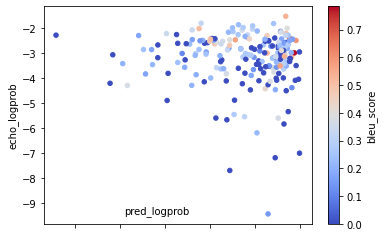

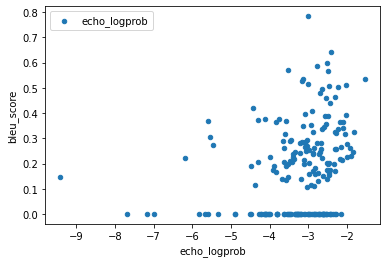

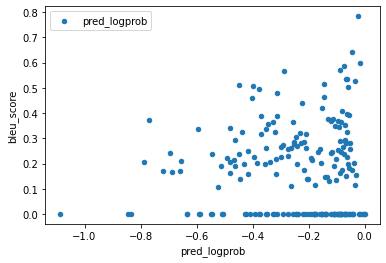

In [16]:
from pathlib import Path
import jsonlines
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt


# metrics_path = Path("metrics") / "wmt19_de_to_en__text-curie-001__200_examples__metrics.json"
# score_name = "bleu_score"
# metrics_path = Path("metrics") / "wmt19_en_to_de__text-curie-001__200_examples__metrics.jsonl"
metrics_path = Path("metrics") / "wmt19_de_to_en__text-davinci-002__200_examples__metrics.jsonl"
# metrics_path = Path("metrics") / "wmt19_en_to_de__text-davinci-002__200_examples__metrics.jsonl"
# metrics_path = Path("metrics") / "wmt19_de_to_en__text-curie-001__200_examples__metrics.jsonl"
# metrics_path = Path("metrics") / "wmt19_ru_to_en__text-davinci-002__200_examples__metrics.jsonl"
# score_name = "rouge2_score"
# score_name = "rougeL_score"
score_name = "bleu_score"

if metrics_path.suffix == ".jsonl":
    with jsonlines.open(metrics_path, 'r') as reader:
        metrics = list(reader.iter())
elif metrics_path.suffix == ".json":
    metrics = json.loads(metrics_path.read_text())
else:
    raise ValueError()

metrics = pd.DataFrame(metrics)
print(f"num examples: {len(metrics)}")
metrics = metrics.rename(columns={col: col.replace("perplexity", "logprob") for col in metrics.columns if "perplexity" in col})
# metrics["pred_prob"] = np.exp(metrics["pred_logprob"])
# metrics["echo_prob"] = np.exp(metrics["echo_logprob"])
# metrics = metrics.loc[metrics["bleu_score"] > 0]

estimators = ["pred_logprob", "echo_logprob", "pred_prob", "echo_prob"]
estimators = set(estimators).intersection(metrics.columns)
correlation_method = ["pearson","kendall", "spearman"]
correlations = []
for col in estimators:
    for method in correlation_method:
        corr = metrics[col].corr(metrics[score_name], method=method)
        correlations.append({"estimator": col, "method": method, "value": corr})
correlations = pd.DataFrame(correlations)
correlations = correlations.sort_values(["method", "value"], ascending=False)
display(correlations)

ax = metrics.plot(x="pred_logprob", y="echo_logprob", c=score_name, kind='scatter', cmap="coolwarm")
plt.text(0.3,0.05,"pred_logprob",transform=ax.transAxes)

for col in estimators:
    metrics.plot(x=col, y=score_name, label=col, kind='scatter')


In [10]:
from torch import nn
from torch import tensor
from torch.optim import AdamW, SGD
from tqdm import tqdm
import torch
from sklearn.svm import SVR


pred = metrics["pred_logprob"].values
echo = metrics["echo_logprob"].values
targets = metrics[score_name].values
features = np.vstack([pred, echo]).T

model_type = "svr_linear"
if "logistic" in model_type:
    if model_type == "explicit_ploynomial_logistic_regression":
        features = np.vstack([pred**2, pred*echo, echo**2, pred, echo]).T
    features = tensor(features, dtype=torch.float32)
    targets = tensor(targets, dtype=torch.float32)

    model = nn.Linear(in_features=features.shape[1], out_features=1)
    optimizer = AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    epochs = 2000
    prog_bar = tqdm(range(epochs))
    for _ in prog_bar:
        res = model(features).flatten()
        loss = loss_fn(res, targets)
        prog_bar.set_description(f"{loss.item():3f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
elif model_type == "svr_poly":
    model = SVR(kernel="poly", degree=2, verbose=2)
    model.fit(features, targets)
elif model_type == "svr_rbf":
    model = SVR(kernel="rbf", verbose=2)
    model.fit(features, targets)
elif model_type == "svr_linear":
    model = SVR(kernel="linear", verbose=2)
    model.fit(features, targets)
    print(f"\n\nLinearSVR coeffs: pred={model.coef_[0,0]:.3f}, echo={model.coef_[0,1]:.3f}, intercept={model.intercept_[0]:.3f}\n\n")
else:
    raise ValueError(f"Unsupported model type '{model_type}'")



[LibSVM].


LinearSVR coeffs: pred=0.055, echo=0.014, intercept=0.345

*
optimization finished, #iter = 458
obj = -3.770064, rho = -0.344546
nSV = 48, nBSV = 45



-0.04855670645144329

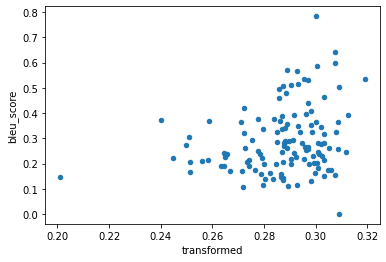

In [14]:
# weights = torch.concat([model.weight.flatten(), model.bias.flatten()]).data.numpy()
if isinstance(model, nn.Module):
    transformed = model(features).flatten().sigmoid().data.numpy()
else:
    transformed = model.predict(features)
pd.DataFrame({"transformed": transformed, score_name: metrics[score_name]}).plot(x="transformed", y=score_name, kind="scatter")
pd.Series(transformed).corr(metrics[score_name], method="spearman")

<AxesSubplot:xlabel='pred_logprob', ylabel='echo_logprob'>

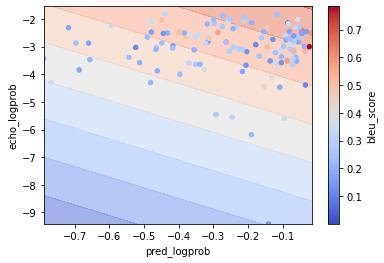

In [12]:
%matplotlib inline
mesh_density = 100
x_mesh = np.linspace(metrics["pred_logprob"].min(), metrics["pred_logprob"].max(), mesh_density)
y_mesh = np.linspace(metrics["echo_logprob"].min(), metrics["echo_logprob"].max(), mesh_density)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
shape = x_mesh.shape
x_mesh = x_mesh.flatten()
y_mesh = y_mesh.flatten()

features_mesh = np.vstack([x_mesh,y_mesh]).T
if isinstance(model, nn.Module):
    if model_type == "explicit_ploynomial_logistic_regression":
        features_mesh = np.vstack([x_mesh**2,x_mesh*y_mesh,y_mesh**2,x_mesh,y_mesh]).T
    features_mesh = tensor(features_mesh, dtype=torch.float32)
    model_res = model(features_mesh).sigmoid().flatten().data.numpy()
else:
    model_res = model.predict(features_mesh)

fig, ax = plt.subplots()
ax.contourf(x_mesh.reshape(shape), y_mesh.reshape(shape), model_res.reshape(shape), cmap=plt.cm.coolwarm, alpha=0.5)
metrics.plot(x="pred_logprob", y="echo_logprob", c=score_name, kind='scatter', cmap="coolwarm", ax=ax)
